This notebook can be used to train diffusion model. All the running script is included in this file.

In [1]:
%%capture
!pip install torch torchvision
!pip install omegaconf pytorch_lightning
!pip install -q -U einops datasets tqdm
!pip install matplotlib==3.1.3
!pip install wandb
!pip install -U scikit-image
!pip install evalutils==0.3.1
!pip install SimpleITK==2.0.2
!pip install scikit-learn==0.24.2
!pip install scipy==1.6.3
!pip install python-dotenv==1.0.0

In [2]:
%%capture
!pip install h5py
!pip install tifffile

In [1]:
import sys, os
import matplotlib.pyplot as plt
import numpy as np
CURR_DIR = os.path.dirname('__file__')
ROOT_DIR=os.path.join(os.getcwd() ,'..')
sys.path.append(ROOT_DIR)

from omegaconf import OmegaConf
#load configs
config = OmegaConf.load(os.path.join(ROOT_DIR,'run_scripts/configs/exp01_brain_mr_ixi_gaussian_config.yaml'))

### use the below code to generate hdf5 files from *.nii.gz files

In [2]:
# # #--> HDF5 files for 1BA001 sample is already created. <--#

# from utils.create_training_images import save_as_hdf5, create_folder
# PATH = "/dss/dsshome1/0D/ge59suz2/thesis/code/dm4mi/conditional-dm4mi/run_scripts/data/brain/" # path to your code
# SAMPLE = "1BA012"
# mr_path = PATH + SAMPLE + "/mr.nii.gz"
# ct_path = PATH + SAMPLE + "/ct.nii.gz"
# image_size = config.model.params.image_size
# bs = 16 # batch_size config.model.params.batch_size
# stride = 32

# target_direc_mr = PATH + SAMPLE + "/mr_h5files_"+str(image_size)+"x"+str(image_size)+"_bs_"+str(bs)+"_s_"+str(stride) # hdf5 files will be saved here.
# target_direc_ct = PATH + SAMPLE + "/ct_h5files_"+str(image_size)+"x"+str(image_size)+"_bs_"+str(bs)+"_s_"+str(stride) # hdf5 files will be saved here.
# '''
# Parameters
# -------
# :image_size: output size of the volumes
# :stride: at what interval to cut the volume
# '''
# save_as_hdf5(inputpath=mr_path, datasetname="mr_"+SAMPLE, targetdir=target_direc_mr, image_size=image_size, stride=stride, batch_size=bs)
# save_as_hdf5(inputpath=ct_path, datasetname="ct_"+SAMPLE, targetdir=target_direc_ct, image_size=image_size, stride=stride, batch_size=bs)

In [4]:
import wandb
!wandb login

wandb: Currently logged in as: pimakshay (thesis-dm). Use `wandb login --relogin` to force relogin


In [2]:
from models.ddpm_conditioned import ConditionDDPM
from utils.initialize_configs import instantiate_from_configs
# paste the path to saved checkpoints
PATH_TO_CHKPTS = '/dss/dsshome1/0D/ge59suz2/thesis/code/dm4mi/conditional-dm4mi-newds/run_scripts/lightning_logs/version_iwuheluo/checkpoints/'
# CHKPT_NAME = '020823-103558_ixi_lastckpt_tloss_0.0059.ckpt' #var=0.01
CHKPT_NAME = '170823-031253_ixi_lastckpt_tloss_0.0069.ckpt' #var=0.01
PATH_TO_CHKPTS = PATH_TO_CHKPTS + CHKPT_NAME
datasetType='ixi'
model = instantiate_from_configs(config.model)
print("Model lr: ",model.learning_rate)
ddpmModel = ConditionDDPM.load_from_checkpoint(PATH_TO_CHKPTS, dataset=model.dataset_dict)
#ConditionDDPM.load_from_checkpoint(PATH_TO_CHKPTS)
print("Loaded Model lr: ",ddpmModel.learning_rate)

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using 711 IXI images 
Model lr:  2e-06
Using 711 IXI images 
Loaded Model lr:  2e-06


In [3]:
%%capture
ddpmModel.cuda()

In [9]:
for key in batch.keys():
    print(key)

NameError: name 'batch' is not defined

In [10]:
len(ddpmModel.noisy_train_dataset)

497

In [11]:
def show_images(dataset, num_samples=24, cols=4, random=True, save_all=False, filename="abc.png"):
    """ Plots some samples from the dataset """
    random_img_idx = np.random.randint(0, high=len(dataset), size=len(dataset), dtype=int)
    rows = int(num_samples//cols)
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(14,14))    
    img_count=0
    for i in range(rows):
        for j in range(cols):
            random_index = random_img_idx[i*cols + j] if random else img_count#int(np.random.random()*len(dataset))
            img = dataset[random_index] # use for stanford_Cars
            out = img.numpy() #.reshape(ddpmModel.image_size, ddpmModel.image_size)
            axes[i, j].imshow(out.reshape(128,128), cmap='gray')    
            img_count = img_count + 1    
    if save_all:
        assert filename is not None, "Filename missing.."
        plt.savefig(filename)

In [12]:
# plot training datset
show_images(dataset=ddpmModel.noisy_train_dataset, num_samples=12, cols=4, random=False, save_all=False, filename="SC_trainset") 

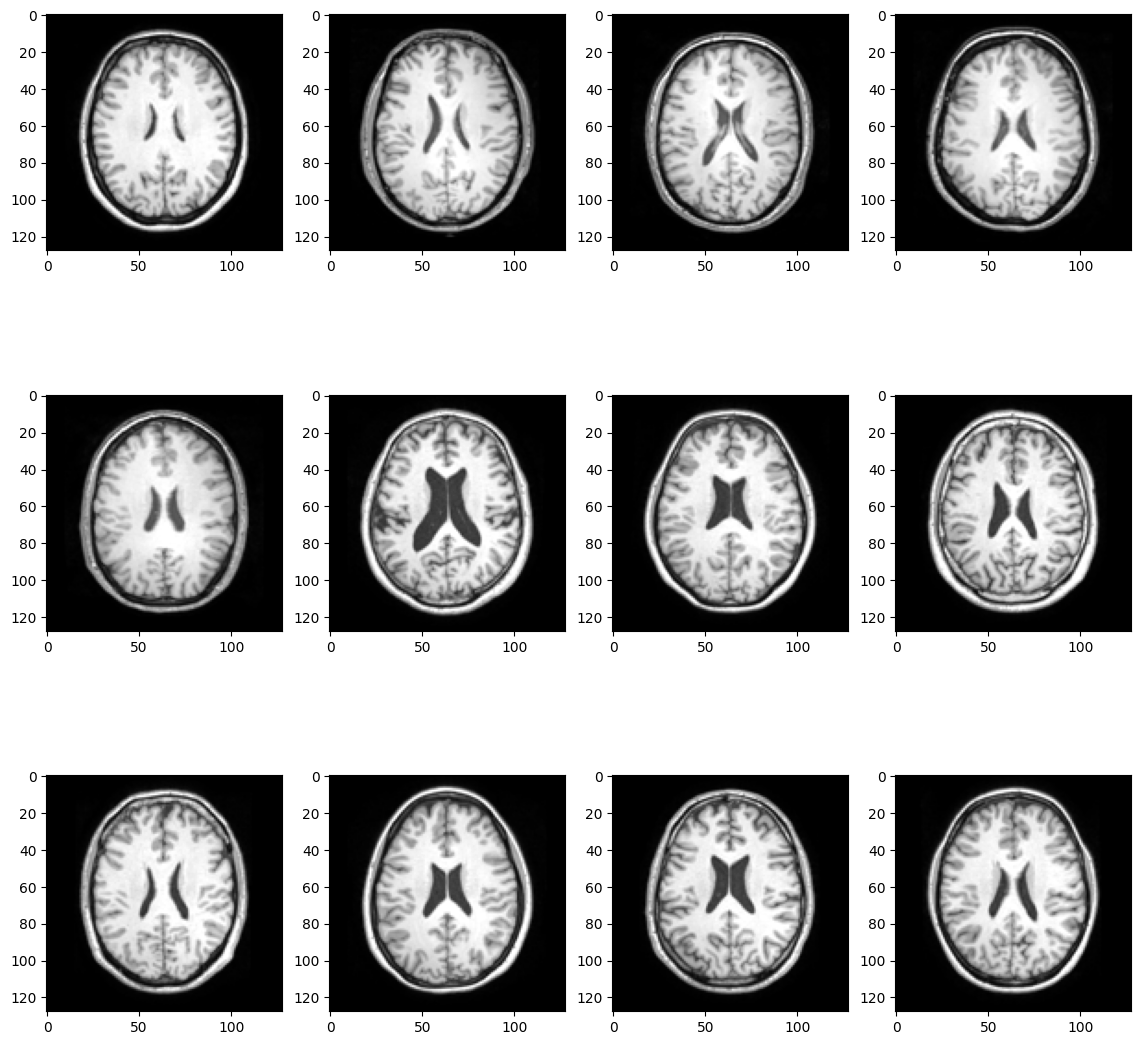

In [13]:
show_images(dataset=ddpmModel.train_dataset, num_samples=12, cols=4, random=False, save_all=False, filename="SC_trainset") 

## DDPM Sampling

In [4]:
import numpy as np
import torch

from diffusion_modules.diffusion_utils.dataloader import CombinedDataset
import torch
num_of_samples = 10
img_size = ddpmModel.image_size
prior_test_dataset = torch.utils.data.Subset (ddpmModel.test_dataset, np.arange(num_of_samples))
noisy_test_dataset = torch.utils.data.Subset (ddpmModel.noisy_test_dataset, np.arange(num_of_samples))

test_dataset = CombinedDataset(noisy_test_dataset, prior_test_dataset)
test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=1, num_workers=4, shuffle=False
)
i=0
prior_test_images = []
noisy_test_images = []
for i,img in enumerate(test_dataloader):
    if i<=num_of_samples:
        noisy_test_images.append(img["x_cond"])
        prior_test_images.append(img["x_prior"])
    else: 
        break

In [3]:
import torch
torch.rand(1)


tensor([0.8702])

In [4]:
prior_test_images_stacked =  torch.stack(prior_test_images)
noisy_test_images_stacked =  torch.stack(noisy_test_images)

NameError: name 'prior_test_images' is not defined

In [7]:
prior_test_images_stacked.shape

torch.Size([10, 1, 1, 128, 128])

In [8]:
test_noisy_images = noisy_test_images_stacked.reshape(num_of_samples,1,img_size,img_size).to(device='cuda')
test_prior_images = prior_test_images_stacked.reshape(num_of_samples,1,img_size,img_size).to(device='cuda')

In [9]:
# Sampling from the trained model (DDPM Sampling)
ddpmModel.cuda()
ddpmModel.clip_denoised = True
ddpmModel.log_every_t = 100
num_samples = num_of_samples # samples n images
samples_test = ddpmModel.sample(cond=test_noisy_images[:num_of_samples].float(),batch_size=num_samples)

Sampling t: 100%|██████████| 1000/1000 [01:43<00:00,  9.67it/s]


In [10]:
samples_test.min()

tensor(0., device='cuda:0')

In [11]:
samples_test_clamped = samples_test #.clamp_(0,1)

## Plotting Results

In [13]:
!pip install PyWavelets

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 6.8 MB 3.8 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [14]:
diff_gt_samples = torch.abs(samples_test_clamped - test_prior_images[:num_samples])

# Non-local means
from skimage import data, img_as_float
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.metrics import peak_signal_noise_ratio
from skimage.util import random_noise

noisy = test_noisy_images[:num_samples].cpu().squeeze()

# estimate the noise standard deviation from the noisy image
sigma_est = np.mean(estimate_sigma(noisy, channel_axis=-1))
print(f'estimated noise standard deviation = {sigma_est}')

patch_kw = dict(patch_size=5,      # 5x5 patches
                patch_distance=6,  # 13x13 search area
                channel_axis=-1)

# slow algorithm
denoise = denoise_nl_means(noisy, h=1.15 * sigma_est, fast_mode=False,
                           **patch_kw)
denoise_nlm_slow = denoise.reshape(num_samples,1,img_size,img_size)

# slow algorithm, sigma provided
denoise2_nlm_slow = denoise_nl_means(noisy, h=0.8 * sigma_est, sigma=sigma_est,
                            fast_mode=False, **patch_kw).reshape(num_samples,1,img_size,img_size)

# fast algorithm
denoise_nlm_fast = denoise_nl_means(noisy, h=0.8 * sigma_est, fast_mode=True,
                                **patch_kw).reshape(num_samples,1,img_size,img_size)

# fast algorithm, sigma provided
denoise2_nlm_fast = denoise_nl_means(noisy, h=0.6 * sigma_est, sigma=sigma_est,
                                 fast_mode=True, **patch_kw).reshape(num_samples,1,img_size,img_size)

estimated noise standard deviation = 0.09519119157353884


torch.Size([10, 1, 128, 128])

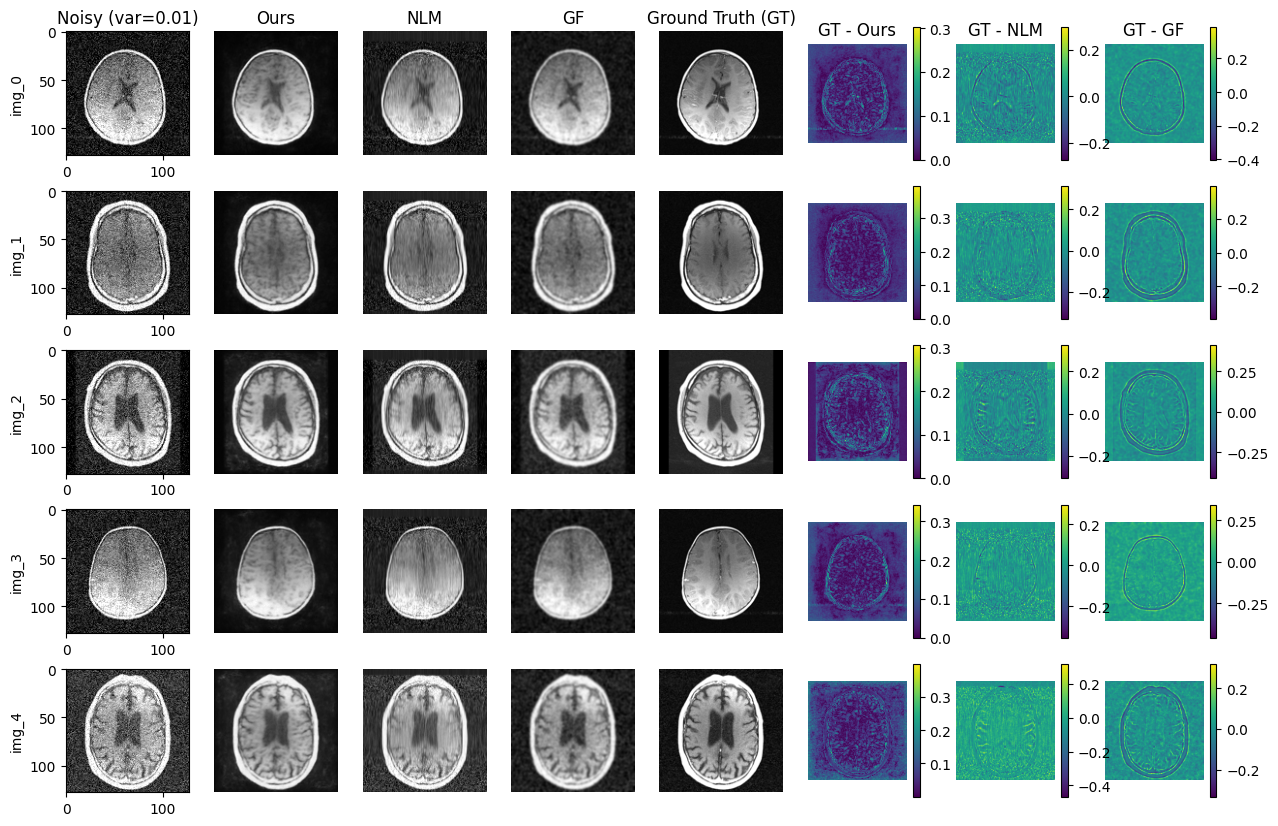

In [17]:
# Plot gt, noisy, denoised and difference images
from scipy import ndimage as nd
from matplotlib.colors import Normalize
from matplotlib import cm
cols = 8
nsamples=5
rows = nsamples
fig, ax = plt.subplots(rows, cols, figsize=(15, 10))
for i in range(rows):
    
        ax[i][0].imshow(test_noisy_images[i].cpu().numpy().reshape(img_size,img_size), cmap='gray')
#         ax[i][0].axis('off')
        ax[i][0].set_ylabel("img_"+str(i))
        ax[i][1].imshow(samples_test_clamped[i].cpu().numpy().reshape(img_size,img_size), cmap='gray')
        ax[i][1].axis('off')

        ax[i][2].imshow(denoise2_nlm_slow[i].reshape(img_size,img_size), cmap='gray')
        ax[i][2].axis('off')
        
        ax[i][3].imshow(nd.gaussian_filter(test_noisy_images[i].cpu().numpy(), sigma=1).reshape(img_size,img_size), cmap='gray')
        ax[i][3].axis('off')
        
        ax[i][4].imshow(test_prior_images[i].cpu().numpy().reshape(img_size,img_size), cmap='gray')
        ax[i][4].axis('off')

        min_value = diff_gt_samples[i].min()
        max_value = diff_gt_samples[i].max()
        min_value_gf = (nd.gaussian_filter(test_noisy_images[i].cpu().numpy(), sigma=1) - test_prior_images[i].cpu().numpy()).min()
        max_value_gf = (nd.gaussian_filter(test_noisy_images[i].cpu().numpy(), sigma=1) - test_prior_images[i].cpu().numpy()).max()
        min_value_nlm = (denoise2_nlm_slow[i] - test_prior_images[i].cpu().numpy()).min()
        max_value_nlm = (denoise2_nlm_slow[i] - test_prior_images[i].cpu().numpy()).max()
        
        ax[i][5].imshow(diff_gt_samples[i].cpu().numpy().reshape(img_size,img_size), norm=Normalize(vmin=min_value, vmax=max_value))
        ax[i][5].axis('off')
        fig.colorbar(cm.ScalarMappable(norm=Normalize(vmin=min_value, vmax=max_value)), ax=ax[i][5])
        
        ax[i][6].imshow((denoise2_nlm_slow[i] - test_prior_images[i].cpu().numpy()).reshape(img_size,img_size), norm=Normalize(vmin=min_value_nlm, vmax=max_value_nlm))
        ax[i][6].axis('off')
        fig.colorbar(cm.ScalarMappable(norm=Normalize(vmin=min_value_nlm, vmax=max_value_nlm)), ax=ax[i][6])
        
        ax[i][7].imshow((nd.gaussian_filter(test_noisy_images[i].cpu().numpy(), sigma=1) - test_prior_images[i].cpu().numpy()).reshape(img_size,img_size), norm=Normalize(vmin=min_value_gf, vmax=max_value_gf))
        ax[i][7].axis('off')
        fig.colorbar(cm.ScalarMappable(norm=Normalize(vmin=min_value_gf, vmax=max_value_gf)), ax=ax[i][7])
        
        if i==0:
            ax[i,0].set_title('Noisy (var=0.01)')
            ax[i,1].set_title('Ours')
            ax[i,2].set_title('NLM')
            ax[i,3].set_title('GF')
            ax[i,4].set_title('Ground Truth (GT)')
            ax[i,5].set_title('GT - Ours')
            ax[i,6].set_title('GT - NLM')
            ax[i,7].set_title('GT - GF')
# plt.savefig("results/var=0.05/denoise_mr_param_eps_with_nlm_gf.png")

## Calculate metrics

In [16]:
# metric for gaussian filter
from metrics.image_metrics import ImageMetrics

#applying gaussian filter
gf_results = nd.gaussian_filter(test_noisy_images[:num_samples].cpu().numpy(), sigma=1)

mask = None #np.ones(samples.shape)

metrics = ImageMetrics()
dynamic_range = 1-0 #1 - -1

print("Initial difference Noisy vs GT: ", metrics.image_scores(test_prior_images[:num_samples].cpu().numpy(), test_noisy_images[:num_samples].cpu().numpy(), 
                           mask, dynamic_range))

print("Results for Our model: ", metrics.image_scores(test_prior_images[:num_samples].cpu().numpy(), samples_test_clamped[:num_samples].cpu().numpy(), 
                           mask, dynamic_range))

print("Results for NLM slow: ", metrics.image_scores(test_prior_images[:num_samples].cpu().numpy(), denoise_nlm_slow, 
                           mask, dynamic_range))
print("Results for NLM slow with sigma: ", metrics.image_scores(test_prior_images[:num_samples].cpu().numpy(), denoise2_nlm_slow, 
                           mask, dynamic_range))
print("Results for NLM fast: ", metrics.image_scores(test_prior_images[:num_samples].cpu().numpy(), denoise_nlm_fast, 
                           mask, dynamic_range))
print("Results for NLM fast with sigma: ", metrics.image_scores(test_prior_images[:num_samples].cpu().numpy(), denoise2_nlm_fast, 
                           mask, dynamic_range))

print("Results for Gaussian Filter: ", metrics.image_scores(test_prior_images[:num_samples].cpu().numpy(), gf_results[:num_samples], 
                           mask, dynamic_range))

Initial difference Noisy vs GT:  {'mae': 0.07356897001025406, 'ssim': 0.731317937374115, 'psnr': 20.651067683898443}
Results for Our model:  {'mae': 0.0543575596956849, 'ssim': 0.8713687062263489, 'psnr': 23.658572318939708}
Results for NLM slow:  {'mae': 0.04920354992727317, 'ssim': 0.8290584683418274, 'psnr': 23.830487995952296}
Results for NLM slow with sigma:  {'mae': 0.046181939426292846, 'ssim': 0.8425006866455078, 'psnr': 24.261925241984066}
Results for NLM fast:  {'mae': 0.055542969774705006, 'ssim': 0.7979050874710083, 'psnr': 22.890655632684556}
Results for NLM fast with sigma:  {'mae': 0.04751295347001543, 'ssim': 0.8352746367454529, 'psnr': 24.024612922527034}
Results for Gaussian Filter:  {'mae': 0.09434905176812439, 'ssim': 0.49200114607810974, 'psnr': 16.867533950192243}


In [38]:
num_samples

5

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
cols=4
rows=rows=int(num_samples // cols) #5 #ddpmModel.batch_size // cols
img_count = 0

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(14,14))
# random_img_idx = np.random.randint(0, high=samples.shape[0], size=samples.shape[0], dtype=int)
# img_count = 0
for i in range(rows):
    for j in range(cols):        
#         if img_count < len(samples[-1]):
#             axes[i, j].imshow(samples[-1][img_count].reshape(ddpmModel.image_size, ddpmModel.image_size, ddpmModel.channels))
        axes[i, j].imshow(samples_test[img_count].cpu().numpy().reshape(img_size,img_size), cmap="gray") #use this statement for cifar10
        img_count+=1
# plt.savefig("results/mr/var=0.1/v_198105_testv0_mr_128_denoised_images_gaussian.png")

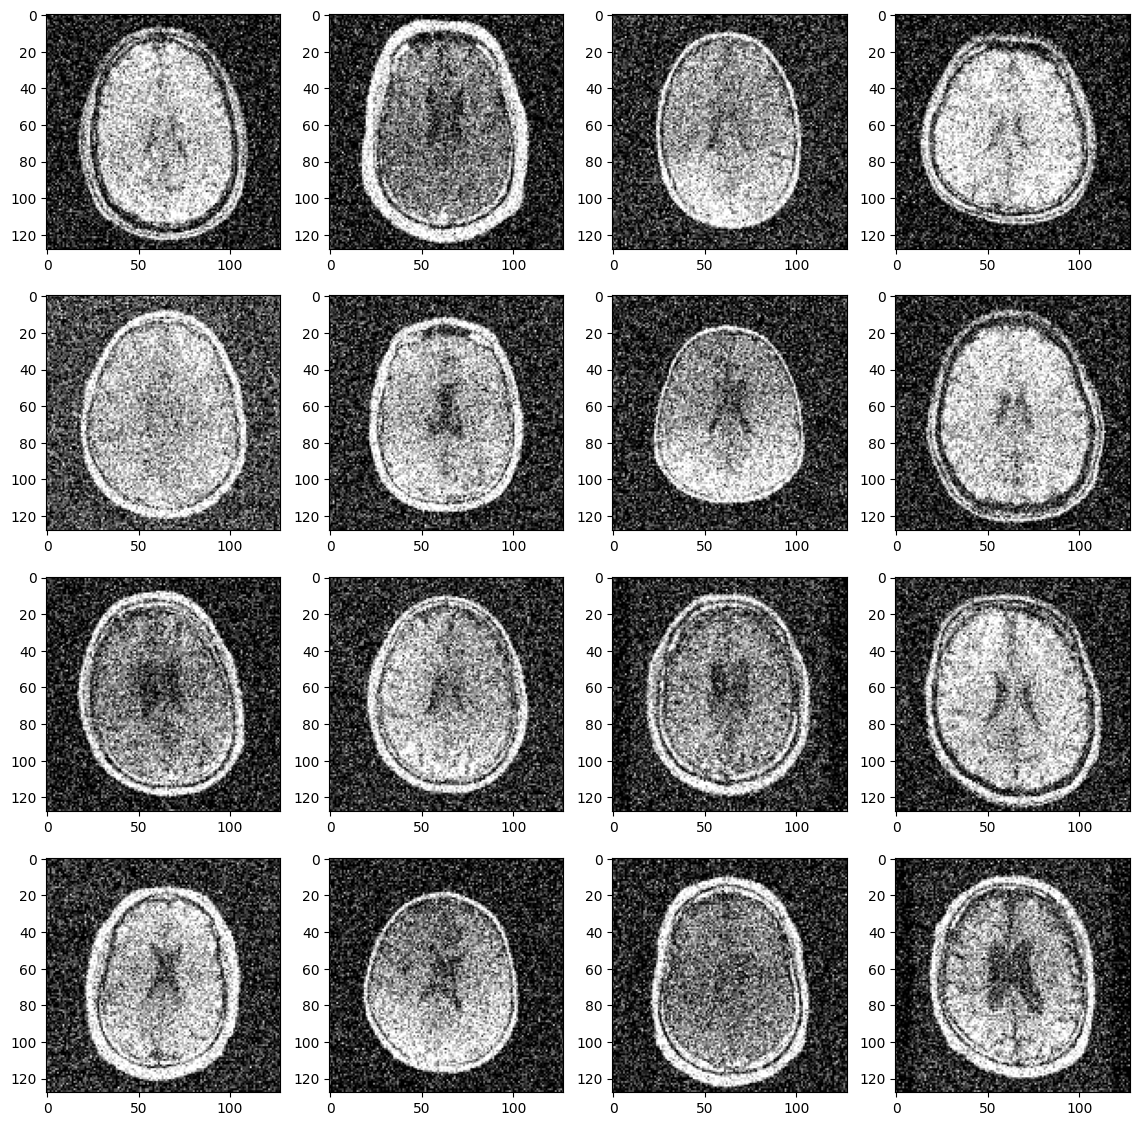

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
cols=4
rows=rows=int(num_samples // cols) #5 #ddpmModel.batch_size // cols
img_count = 0

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(14,14))
for i in range(rows):
    for j in range(cols):        
#         if img_count < len(samples[-1]):
#             axes[i, j].imshow(samples[-1][img_count].reshape(ddpmModel.image_size, ddpmModel.image_size, ddpmModel.channels))
        axes[i, j].imshow(test_noisy_images[img_count].cpu().numpy().reshape(img_size,img_size), cmap="gray") #use this statement for cifar10
        img_count+=1
# plt.savefig("results/mr/var=0.1/v_198105_testv1_mr_128_noisy_images_gaussian.png")

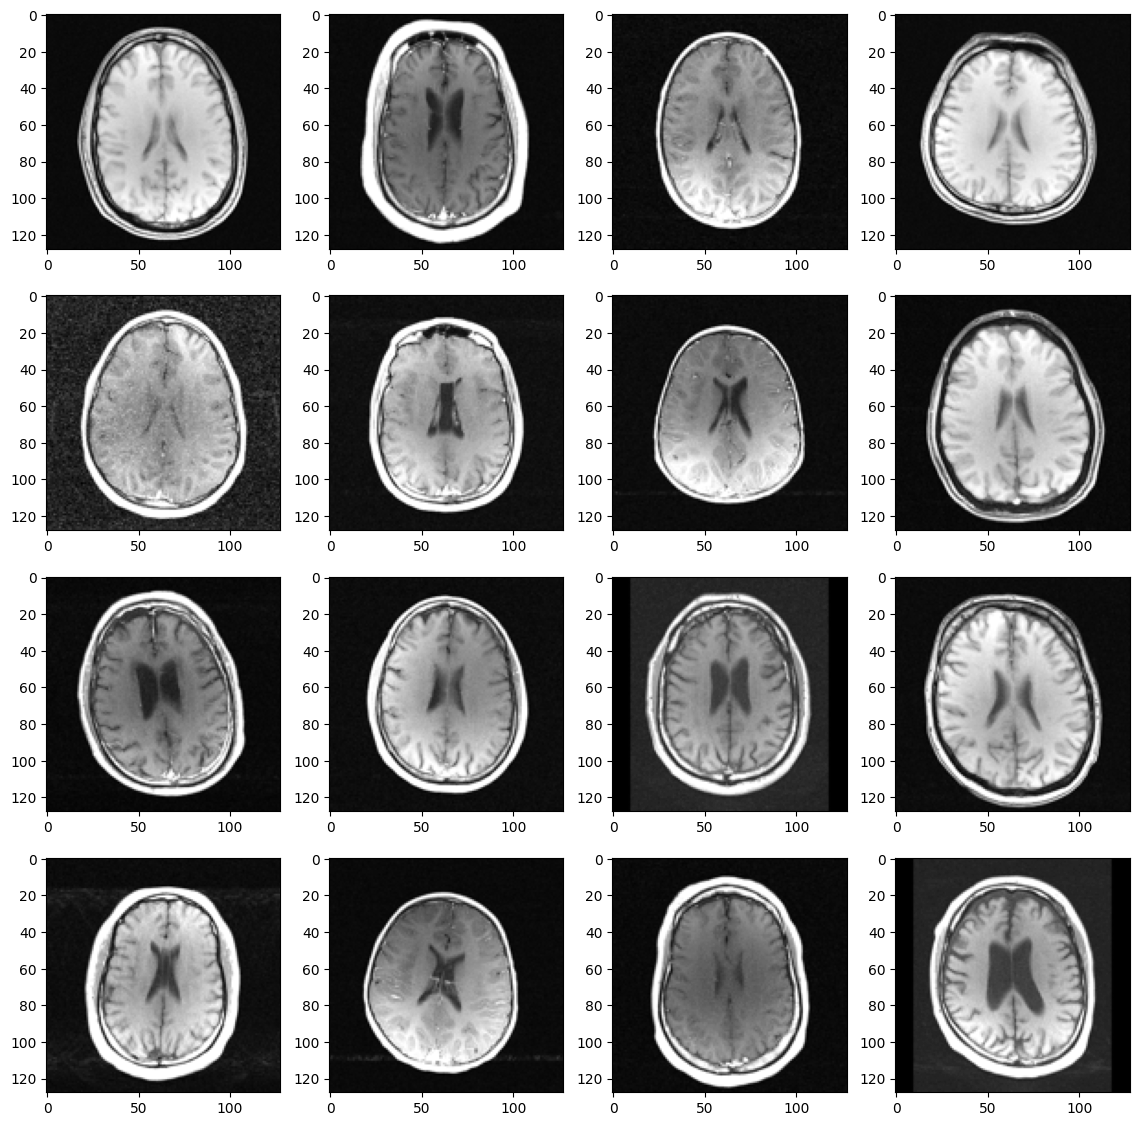

In [53]:
import matplotlib.pyplot as plt
import numpy as np
cols=4
rows=rows=int(num_samples // cols) #5 #ddpmModel.batch_size // cols
img_count = 0

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(14,14))
for i in range(rows):
    for j in range(cols):        
#         if img_count < len(samples[-1]):
#             axes[i, j].imshow(samples[-1][img_count].reshape(ddpmModel.image_size, ddpmModel.image_size, ddpmModel.channels))
        axes[i, j].imshow(test_prior_images[img_count].cpu().numpy().reshape(img_size,img_size), cmap="gray") #use this statement for cifar10
        img_count+=1
# plt.savefig("results/mr/var=0.1/v_198105_testv1_mr_128_gt_images_gaussian.png")

In [23]:
def detect_anomaly(x, rec):
    anomaly_map = torch.abs(x - rec)
    anomaly_score = torch.sum(anomaly_map, dim=(1, 2, 3))
    return {
        'reconstruction': rec,
        'anomaly_map': anomaly_map,
        'anomaly_score': anomaly_score
    }

In [26]:
r = detect_anomaly(test_prior_images, samples_test)

In [28]:
test_prior_images.shape

torch.Size([16, 1, 128, 128])

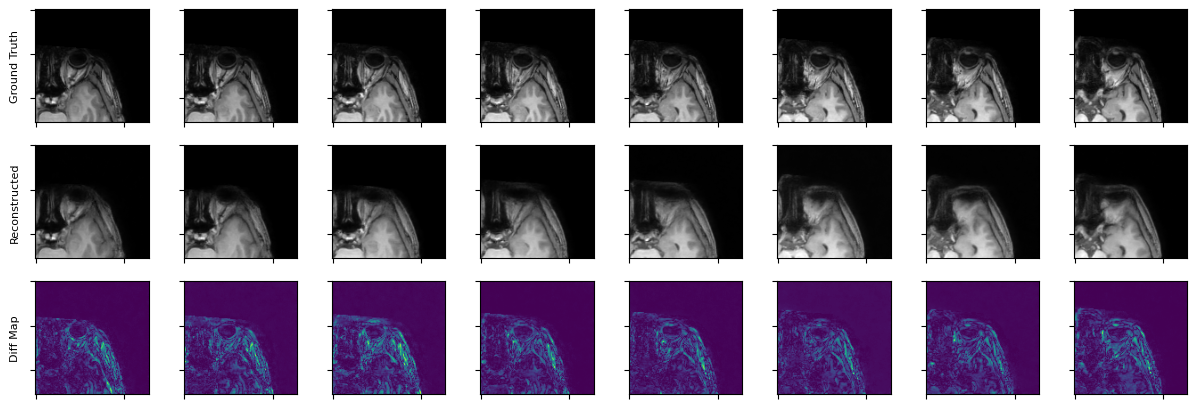

In [51]:
with torch.inference_mode():
#     results = model.detect_anomaly(batch)
    batch = test_prior_images
    reconstructions = r['reconstruction']
    anomaly_map = r['anomaly_map']

# Plot images and reconstructions
num = 8
fig, ax = plt.subplots(3, num, figsize=(15, 5))
ax[0][0].set_ylabel('Ground Truth', fontsize=8)
ax[1][0].set_ylabel('Reconstructed', fontsize=8)
ax[2][0].set_ylabel('Diff Map', fontsize=8)
for i in range(num):
    ax[0][i].imshow(test_prior_images[i].cpu().squeeze(), cmap='gray')
    ax[0][i].set_xticklabels([]) #.axis('off')
    ax[0][i].set_yticklabels([])
    ax[1][i].imshow(reconstructions[i].cpu().squeeze(), cmap='gray')
#     ax[1][i].axis('off')
    ax[1][i].set_xticklabels([]) #.axis('off')
    ax[1][i].set_yticklabels([])
    ax[2][i].imshow(anomaly_map[i].cpu().squeeze())
#     ax[2][i].axis('off')
    ax[2][i].set_xticklabels([]) #.axis('off')
    ax[2][i].set_yticklabels([])
# axes[i,0].set_ylabel('x_'+str(5 + int(10*lam))+'\nλ={:.2f}'.format(lam),  fontsize=6)
#     axes[i,1].imshow(linear_img_ls[i][0,0].cpu(), cmap="Greys"); #axes[i,1].set_title('linear')

plt.savefig("results/mr/recon_train.png")

In [32]:
samples_test.min()

tensor(-1.0480, device='cuda:0')

In [33]:
samples_clamped = samples_test.clamp_(-1,1)

## Calculate metrics

In [34]:
from metrics.image_metrics import ImageMetrics

mask = None #np.ones(samples.shape)

metrics = ImageMetrics()
dynamic_range = 1 - -1

print(metrics.image_scores(test_prior_images[:num_samples].cpu().numpy(), samples_clamped[:num_samples].cpu().numpy(), 
                           mask, dynamic_range))

{'mae': 0.036549234955384396, 'ssim': 0.8649387955665588, 'psnr': 29.47290453928249}


## DDIM Sampling

In [ ]:
from models.ddim import DDIM
sampler = DDIM(ddpmModel)
# total sampled images: batch_size==128
ddim_steps = 200
ddim_eta = 0.995
scale = 3.0 
num_of_samples = 200
use_DDPM_sampling = False
samples_ddim, intermediate_samples = sampler.sample(S=ddim_steps,
                                    batch_size=num_of_samples,
                                    shape=[ddpmModel.channels, ddpmModel.image_size, ddpmModel.image_size],
                                    use_ddpm_sampling=use_DDPM_sampling,
                                    verbose=False,
                                    log_every_t=1,
                                    eta=ddim_eta)

In [34]:
samples_ddim.shape

torch.Size([200, 1, 64, 64])

In [35]:
images = []
for batch in ddpmModel.train_dataloader():
    if len(images)<10:
        images.append(batch.reshape(64,1,64,64))

In [36]:
images_stacked = np.stack(images)

In [37]:
i = images_stacked.reshape(640,1,64,64)

In [38]:
type(samples_ddim)

torch.Tensor

In [39]:
print(metrics.image_scores(i[:200], samples_ddim.cpu().numpy(), mask, dynamic_range))

{'mae': 0.46073035626084413, 'ssim': 0.02352358028292656, 'psnr': 10.559639046598788}


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
cols=4
rows=rows=int(num_samples // cols)
img_count = 0

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(14,14))
for i in range(rows):
    for j in range(cols):        
        axes[i, j].imshow(samples_ddim[img_count].cpu().numpy().reshape(ddpmModel.image_size, ddpmModel.image_size), cmap='Greys') #use this statement for cifar10
        img_count+=1
# plt.savefig("185950_run3_sampled_images.png")

In [48]:
import matplotlib.pyplot as plt
import numpy as np
cols=4
rows=rows=int(num_samples // cols)
img_count = 30

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(14,14))
for i in range(rows):
    for j in range(cols):        
        axes[i, j].imshow(gt_images[0,0][img_count].cpu().numpy().reshape(ddpmModel.image_size, ddpmModel.image_size), cmap='Greys') #use this statement for cifar10
        img_count+=1

In [54]:
from inspect import isfunction
import torch
from torch import nn

def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

In [92]:
import torch
@torch.no_grad()
def interpolate(x1, x2, t = None, lam = 0.5):
    b, *_, device = *x1.shape, x1.device
    t = default(t, ddpmModel.num_timesteps - 1)

    assert x1.shape == x2.shape

    t_batched = torch.full((b,), t, device = device)
    xt1, xt2 = map(lambda x: ddpmModel.q_sample(x, t = t_batched), (x1, x2))

    img = (1 - lam) * xt1 + lam * xt2

    x_start = None

    for i in tqdm(reversed(range(0, t)), desc = 'interpolation sample time step', total = t):
        self_cond = x_start # if ddpmModel.self_condition else None
        img, x_start = ddpmModel.p_sample(img, i)

    return img

In [102]:
b, *_, device = *x1.shape, x1.device

In [75]:
t_batched = torch.full((b,), 100, device = device)

In [89]:
100.to(device='cuda')

SyntaxError: invalid decimal literal (4033861687.py, line 1)

In [108]:
t

tensor([ 1, 87], device='cuda:0')

In [104]:
torch.full((b,), t[0], device = device)

tensor([79], device='cuda:0')

In [110]:
from tqdm.auto import tqdm
x1 = gt_images[0,0][30].reshape(1,64,64).to(device='cuda')
x2 = gt_images[0,0][54].reshape(1,64,64).to(device='cuda')
t = torch.randint(0, 100, (2,), device=ddpmModel.device).long()
interploted_img = interpolate(x1,x2,t)

TypeError: full() received an invalid combination of arguments - got (tuple, list, device=torch.device), but expected one of:
 * (tuple of ints size, Number fill_value, *, tuple of names names, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (tuple of ints size, Number fill_value, *, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
